# Comparing our models to predictions for Sydney Open 2019

Our last tournament in the dataset is Sydney Open - this is a lead up tournament for Australian Open. NOTE: this tournament data was not used as part of training or validation since we stopped our data at 2018, so it should give us a pretty good sense of whether the model is generalizing well to data we have not seen before.

Let's look at our 2 top models and run a prediction and see how well we are doing. These 2 models are Descision Tree Classifiers trained on diff dataset + ohe categorical data. One was trained on dataset from 1985 to 2018. The other trained on 1998 to 2018 data.


# Result

Interestingly, when we are using data that we haven't seen before, we are actually getting better accuracy than our training/test data.

Out of 27 matches, the model misclassified 3 wins and 2 losses. Looking at some of the incorrect prediction, the matches were upset where a lower ranked player actually beat a higher ranked player.

```
Description: ohe-reduced_history_matchup
Model Score: 0.8518518518518519

ROC/AUC Score: 0.8500000000000001
              precision    recall  f1-score   support

        Loss       0.87      0.87      0.87        15
         Win       0.83      0.83      0.83        12

    accuracy                           0.85        27
   macro avg       0.85      0.85      0.85        27
weighted avg       0.85      0.85      0.85        27
```

If we only use a base prediction - ie, only using player rank to predict our outcomes. We would get this for the tournament

```
Description: base_prediction
Model Score: 0.6666666666666666

ROC/AUC Score: 0.6675824175824175
              precision    recall  f1-score   support

        Loss       0.69      0.64      0.67        14
         Win       0.64      0.69      0.67        13

    accuracy                           0.67        27
   macro avg       0.67      0.67      0.67        27
weighted avg       0.67      0.67      0.67        27
```

I think our model is doing pretty good. Around 18% improvement over our base predictions

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5.csv'

START_YEAR = 1985
END_YEAR = 2018

import logging
logging.basicConfig(level=logging.INFO)




In [30]:
report = pd.read_csv(REPORT_FILE)

In [31]:
features_orig = pd.read_csv(FEATURE_FILE)

In [32]:
features_orig.columns

Index(['draw_size', 'round_label', 'tourney_level_label', 'tourney_month',
       'tourney_year', 'p1_age', 'p1_ht', 'p1_rank', 'p1_seed', 'p2_age',
       ...
       'p1_history_win_percentage_diff',
       'p1_history_games_won_percentage_diff',
       'p1_history_sets_won_percentage_diff', 'p1_history_wins_diff',
       'p1_history_losses_diff', 'p1_matchup_wins_diff',
       'p1_matchup_games_diff', 'p1_matchup_sets_diff', 'p1_history_matches',
       'p2_history_matches'],
      dtype='object', length=5300)

### Get Australian Open Data

In [37]:
data = features[(features_orig.tourney_year == 2018) & (features_orig.tourney_id_m001 == 1)]
data.head()

,p1_rank,p2_rank,p1_seed,p2_seed,p1_history_games_won_percentage_diff,p1_history_sets_won_percentage_diff,p1_ht,p2_ht,p1_age,p2_age,...,p2_200611,p2_200615,p2_200624,p2_200630,p2_202090,p2_202130,p2_202358,p2_202359,p2_202385,p2_205734
97275,127,621,23,28,0.506667,0.466667,183.000000,184.673946,28.57,18.43,...,0,1,0,0,0,0,0,0,0,0
97276,51,42,14,12,-0.008412,0.066667,181.000000,196.000000,28.48,28.67,...,0,0,0,0,0,0,0,0,0,0
97277,34,52,8,15,-0.026070,-0.090909,190.000000,188.000000,30.38,30.65,...,0,0,0,0,0,0,0,0,0,0
97278,462,36,27,9,-0.482456,-0.454545,184.673946,188.000000,21.76,36.30,...,0,0,0,0,0,0,0,0,0,0
97279,40,167,11,25,0.141221,0.365385,188.000000,185.127327,34.15,18.89,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import re

def filter_features(data: pd.DataFrame):
    
    print(f'\nBefore: data.shape {data.shape}')

    new_features = data[["p1_rank", "p2_rank", "p1_seed", "p2_seed", "p1_history_games_won_percentage_diff", "p1_history_sets_won_percentage_diff", 
                        "p1_ht", "p2_ht", "p1_age", "p2_age", "p1_matchup_games_won_percentage", "p2_matchup_games_won_percentage",
                        "p1_history_wins_diff", "tourney_level_label", "p1_matchup_sets_won_percentage", "p2_matchup_sets_won_percentage",
                        "tourney_month", "round_label", LABEL_COL]]
             
    surface_cols = [col for col in data.columns if re.match("surface_", col)]
    new_features = pd.concat([new_features, data[surface_cols]], axis=1)

    best_of_cols = [col for col in data.columns if re.match("best_of_", col)]
    new_features = pd.concat([new_features, data[best_of_cols]], axis=1)
             
    player_ioc_cols = [col for col in data.columns if re.match(r"(p1|p2)_ioc_", col)]
    new_features = pd.concat([new_features, data[player_ioc_cols]], axis=1)

    player_id_cols = [col for col in data.columns if re.match(r"(p1|p2)_[\d]+", col)]
    new_features = pd.concat([new_features, data[player_id_cols]], axis=1)

    


    print(f'After: data.shape {new_features.shape}')
    return new_features

data = filter_features(data)


Before: data.shape (27, 5045)
After: data.shape (27, 5045)


In [46]:
AUS_OPEN_FEATURES = '../datasets/2019-sydney-open-features.csv'

if not os.path.exists(AUS_OPEN_FEATURES):
    features = pd.read_csv(FEATURE_FILE)
    data = features[(features.tourney_year == 1998) & (features.tourney_id_m001 == 1)]
    data = filter_features(data)
    data.head()
    data.to_csv(FEATURES, index=False)
else:
    data = pd.read_csv(AUS_OPEN_FEATURES)

In [48]:
data.sample(5)

,p1_rank,p2_rank,p1_seed,p2_seed,p1_history_games_won_percentage_diff,p1_history_sets_won_percentage_diff,p1_ht,p2_ht,p1_age,p2_age,...,p2_200611,p2_200615,p2_200624,p2_200630,p2_202090,p2_202130,p2_202358,p2_202359,p2_202385,p2_205734
12,25,127,2,23,-0.027377,-0.029167,193.000000,183.000000,34.67,28.57,...,0,0,0,0,0,0,0,0,0,0
5,30,53,7,16,0.074969,0.328671,172.000000,184.673946,25.64,27.71,...,0,0,0,0,0,0,0,0,0,0
22,28,27,5,4,0.032258,0.032967,183.000000,178.000000,29.53,30.63,...,0,0,0,0,0,0,0,0,0,0
18,84,55,21,18,0.033316,0.166667,185.127327,184.673946,21.91,21.25,...,0,0,0,0,0,0,0,0,0,0
4,40,167,11,25,0.141221,0.365385,188.000000,185.127327,34.15,18.89,...,0,0,0,0,0,0,0,0,0,0


In [49]:
data_labels = data[LABEL_COL]
print(data_labels.shape)
data_features = data.drop([LABEL_COL], axis=1)
print(data_features.shape)

(27,)
(27, 5044)


In [50]:
report.head()

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
0,LogisticRegression,raw,../datasets/atp_matches_1985-2019_features.csv,1998,2018,0.654153,0.654161,"{""0"": {""0"": 4847, ""1"": 2588}, ""1"": {""0"": 2534,...","{""Loss"": {""precision"": 0.6519166106254203, ""re...",../models/logisticregression-1998-2018-raw.pkl,0.0,0.0,0.0
1,KNeighborsClassifier,raw,../datasets/atp_matches_1985-2019_features.csv,1998,2018,0.585888,0.585877,"{""0"": {""0"": 4300, ""1"": 3052}, ""1"": {""0"": 3081,...","{""Loss"": {""precision"": 0.5848748639825898, ""re...",../models/kneighborsclassifier-1998-2018-raw.pkl,0.0,0.0,0.0
2,DecisionTreeClassifier,raw,../datasets/atp_matches_1985-2019_features.csv,1998,2018,0.596489,0.596465,"{""0"": {""0"": 4349, ""1"": 2944}, ""1"": {""0"": 3032,...","{""Loss"": {""precision"": 0.5963252433840669, ""re...",../models/decisiontreeclassifier-1998-2018-raw...,0.0,0.0,0.0
3,RandomForestClassifier,raw,../datasets/atp_matches_1985-2019_features.csv,1998,2018,0.640108,0.640338,"{""0"": {""0"": 5251, ""1"": 3200}, ""1"": {""0"": 2130,...","{""Loss"": {""precision"": 0.6213465862028162, ""re...",../models/randomforestclassifier-1998-2018-raw...,0.0,0.0,0.0
4,GradientBoostingClassifier,raw,../datasets/atp_matches_1985-2019_features.csv,1998,2018,0.682647,0.682614,"{""0"": {""0"": 4964, ""1"": 2283}, ""1"": {""0"": 2417,...","{""Loss"": {""precision"": 0.684973092314061, ""rec...",../models/gradientboostingclassifier-1998-2018...,0.0,0.0,0.0


# Predicting based on model trained with data from 1998 to 2018

INFO:util.model_util:Loading model from file: ../models/gradientboostingclassifier-1998-2018-ohe-reduced_history_matchup.pkl




Description: ohe-reduced_history_matchup
Model Score: 0.8148148148148148

ROC/AUC Score: 0.8159340659340659
              precision    recall  f1-score   support

        Loss       0.85      0.79      0.81        14
         Win       0.79      0.85      0.81        13

    accuracy                           0.81        27
   macro avg       0.82      0.82      0.81        27
weighted avg       0.82      0.81      0.81        27

      Loss  Win
Loss    11    3
Win      2   11


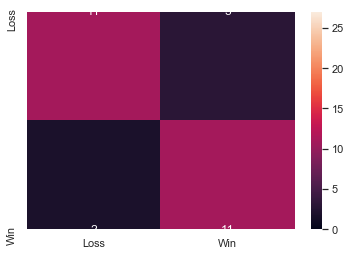

In [51]:
desc = "ohe-reduced_history_matchup"

print(f'\n\nDescription: {desc}')
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == desc)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)
mw.X_test = data_features
mw.y_test = data_labels
mw.predict()
mw.analyze()
plt.show()
    

## Let's look at which match and why we go the prediction wrong

In [52]:
correct_list = (data_labels == mw.y_predict)
correct_idx = [i for i, x in enumerate(correct_list) if x]
wrong_list = (data_labels != mw.y_predict)
wrong_idx = [i for i, x in enumerate(wrong_list) if x]
data_features[wrong_list]     


,p1_rank,p2_rank,p1_seed,p2_seed,p1_history_games_won_percentage_diff,p1_history_sets_won_percentage_diff,p1_ht,p2_ht,p1_age,p2_age,...,p2_200611,p2_200615,p2_200624,p2_200630,p2_202090,p2_202130,p2_202358,p2_202359,p2_202385,p2_205734
2,34,52,8,15,-0.026070,-0.090909,190.0,188.0,30.38,30.65,...,0,0,0,0,0,0,0,0,0,0
14,36,26,9,3,-0.064419,-0.083916,188.0,170.0,36.30,25.40,...,0,0,0,0,0,0,0,0,0,0
19,45,22,13,1,-0.026155,-0.190476,183.0,188.0,36.07,29.98,...,0,0,0,0,0,0,0,0,0,0
20,25,42,2,12,0.036667,0.104167,193.0,196.0,34.67,28.67,...,0,0,0,0,0,0,0,0,0,0
22,28,27,5,4,0.032258,0.032967,183.0,178.0,29.53,30.63,...,0,0,0,0,0,0,0,0,0,0


### Let's use shap to figure out what the model is doing

In [53]:
# load our original feature file to create SHAPE values
X_train_orig, X_test_orig, y_train, y_test = \
    ModelWrapper.get_data(FEATURE_FILE, LABEL_COL, 1998, END_YEAR)


INFO:util.jupyter_util:loading ../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5.csv
INFO:util.jupyter_util:(59239, 5299)


In [54]:
# we need a slightly different function here because label column has already been split out
def filter_features_only(data: pd.DataFrame):
    
    print(f'\nBefore: data.shape {data.shape}')

    new_features = data[["p1_rank", "p2_rank", "p1_seed", "p2_seed", "p1_history_games_won_percentage_diff", "p1_history_sets_won_percentage_diff", 
                        "p1_ht", "p2_ht", "p1_age", "p2_age", "p1_matchup_games_won_percentage", "p2_matchup_games_won_percentage",
                        "p1_history_wins_diff", "tourney_level_label", "p1_matchup_sets_won_percentage", "p2_matchup_sets_won_percentage",
                        "tourney_month", "round_label"]]
             
    surface_cols = [col for col in data.columns if re.match("surface_", col)]
    new_features = pd.concat([new_features, data[surface_cols]], axis=1)

    best_of_cols = [col for col in data.columns if re.match("best_of_", col)]
    new_features = pd.concat([new_features, data[best_of_cols]], axis=1)
             
    player_ioc_cols = [col for col in data.columns if re.match(r"(p1|p2)_ioc_", col)]
    new_features = pd.concat([new_features, data[player_ioc_cols]], axis=1)

    player_id_cols = [col for col in data.columns if re.match(r"(p1|p2)_[\d]+", col)]
    new_features = pd.concat([new_features, data[player_id_cols]], axis=1)

    


    print(f'After: data.shape {new_features.shape}')
    return new_features


X_train = filter_features_only(X_train_orig)
X_test = filter_features_only(X_test_orig)


Before: data.shape (44429, 5299)
After: data.shape (44429, 5044)

Before: data.shape (14810, 5299)
After: data.shape (14810, 5044)


In [ ]:
import shap

shap.initjs()


explainer = shap.TreeExplainer(mw.model, data=X_train.values)
# should I be using the test dataset?
shap_values = explainer.shap_values(data_features.values)


In [57]:
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)


In [58]:
shap_df.head()

,p1_rank,p2_rank,p1_seed,p2_seed,p1_history_games_won_percentage_diff,p1_history_sets_won_percentage_diff,p1_ht,p2_ht,p1_age,p2_age,...,p2_200611,p2_200615,p2_200624,p2_200630,p2_202090,p2_202130,p2_202358,p2_202359,p2_202385,p2_205734
0,-0.345236,0.818579,-0.056170,0.136037,0.339325,-0.000851,-0.059024,1.457800,-0.008220,-0.091833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.002471,0.037316,-0.003916,-0.148535,0.023494,0.000941,-0.028675,-0.092121,-0.016462,0.049357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.180226,0.069820,0.077408,0.016780,-0.012937,0.001224,0.042430,-0.117402,-0.056795,0.069887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.685495,-0.031600,-0.057948,-0.131629,-0.650101,-0.018050,-1.010959,-0.079356,-0.045080,0.122782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035016,0.149367,0.028539,0.071472,0.058767,-0.000248,0.036229,-1.512843,-0.068033,-0.364479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


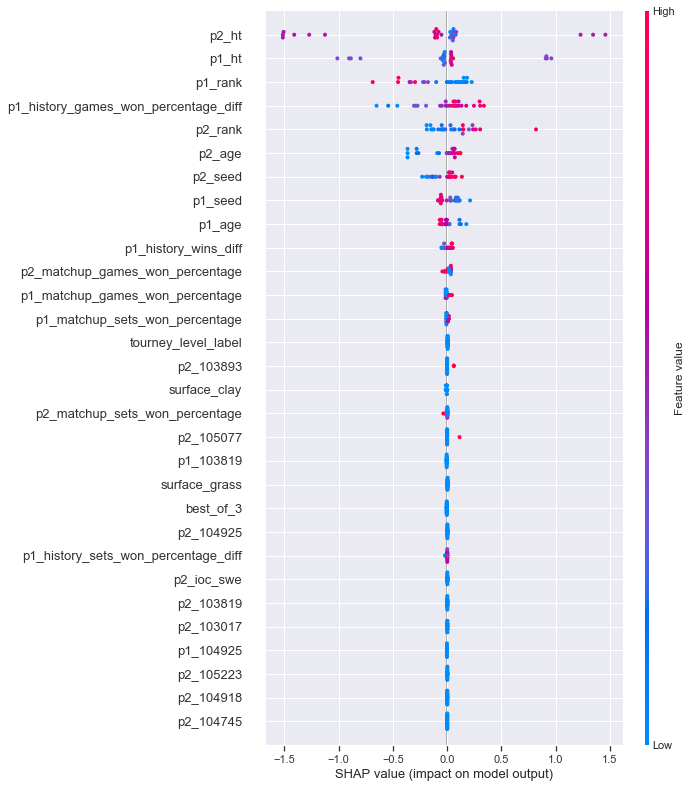

In [59]:
shap.summary_plot(shap_values, data_features, max_display=30)

In [71]:
explainer.expected_value

0.005969229682257216

## SHAP value for an correct prediction

In [66]:
idx = correct_idx[0]

print('Predicted Loss' if mw.y_predict[idx] == 0 else 'Predicted Win')
print('Actual Loss' if y_test.iloc[idx] == 0 else 'Actual Win')

shap.force_plot(explainer.expected_value, 
                     shap_values[idx][:], 
                     data_features.iloc[idx], 
                     data_features.columns)

Predicted Win
Actual Win


## SHAP value for an incorrect predictions

### This is an upset

Player 2 is lower ranked than Player 1, but player 1 won the match. Both height and age are about the same for both

In [67]:
idx = wrong_idx[0]

print('Predicted Loss' if mw.y_predict[idx] == 0 else 'Predicted Win')
print('Actual Loss' if y_test.iloc[idx] == 0 else 'Actual Win')

shap.force_plot(explainer.expected_value, 
                     shap_values[idx][:], 
                     data_features.iloc[idx], 
                     data_features.columns)

Predicted Win
Actual Loss


### This is an upset.

Player 1 is ranked/seeded below Player 2. Also player 1 is coming in with a losing record

In [64]:
idx = wrong_idx[1]

print('Predicted Loss' if mw.y_predict[idx] == 0 else 'Predicted Win')
print('Actual Loss' if y_test.iloc[idx] == 0 else 'Actual Win')

shap.force_plot(explainer.expected_value, 
                     shap_values[idx][:], 
                     data_features.iloc[idx], 
                     data_features.columns)

Predicted Loss
Actual Win


### This is an upset. Player 2 is seeded #1 but Player 1 won

In [68]:
idx = wrong_idx[2]

print('Predicted Loss' if mw.y_predict[idx] == 0 else 'Predicted Win')
print('Actual Loss' if y_test.iloc[idx] == 0 else 'Actual Win')

shap.force_plot(explainer.expected_value, 
                     shap_values[idx][:], 
                     data_features.iloc[idx], 
                     data_features.columns)

Predicted Loss
Actual Win


In [86]:
idx = wrong_idx[3]

print('Predicted Loss' if mw.y_predict[idx] == 0 else 'Predicted Win')
print('Actual Loss' if y_test.iloc[idx] == 0 else 'Actual Win')

shap.force_plot(explainer.expected_value, 
                     shap_values[idx][:], 
                     data_features.iloc[idx], 
                     data_features.columns)

Predicted Win
Actual Win


In [78]:
from util.mapping_util import Mapper

In [80]:
Mapper.get_player_info_by_id(["105077"])

INFO:util.mapping_util:player_id: ['105077']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 12 columns):
id              2503 non-null object
name            2503 non-null object
ht              1654 non-null float64
hand            2503 non-null object
ioc             2503 non-null object
wins            2503 non-null int64
losses          2503 non-null int64
matches         2503 non-null int64
pro_date        2503 non-null object
retire_date     2503 non-null object
years_as_pro    2503 non-null int64
birthday        2503 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 234.8+ KB


,id,name,ht,hand,ioc,wins,losses,matches,pro_date,retire_date,years_as_pro,birthday
36,105077,albert ramos,188.0,L,ESP,180,211,391,2010-04-19,2019-02-25,9,1988-01-24


# Let's double check with our base prediction

Base prediction is if we only used rank/seed to predict results of the matches

In [87]:
data_features["base_predictions"] = data_features["p1_rank"] < data_features["p2_rank"]

In [89]:
base_predictions = data_features["base_predictions"]
data_features = data_features.drop(["base_predictions"], axis=1)

INFO:util.model_util:Loading model from file: ../models/gradientboostingclassifier-1998-2018-ohe-reduced_history_matchup.pkl




Description: base_prediction
Model Score: 0.6666666666666666

ROC/AUC Score: 0.6675824175824175
              precision    recall  f1-score   support

        Loss       0.69      0.64      0.67        14
         Win       0.64      0.69      0.67        13

    accuracy                           0.67        27
   macro avg       0.67      0.67      0.67        27
weighted avg       0.67      0.67      0.67        27

      Loss  Win
Loss     9    5
Win      4    9


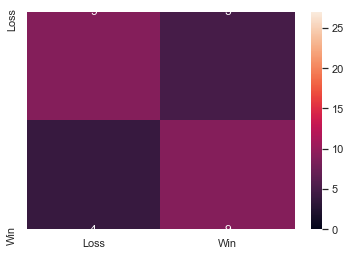

In [90]:
desc = "base_prediction"

print(f'\n\nDescription: {desc}')

mw_base = ModelWrapper.get_model_wrapper_from_report(current_report)
mw_base.X_test = data_features
mw_base.y_test = base_predictions
mw_base.predict()
mw_base.analyze()
plt.show()